In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tff
import pandas as pd
from lmfit.models import QuadraticModel
import ROI

In [2]:
pink = pd.read_pickle('/Users/yungkuo/Google Drive/072116 beads for calibration/pink.pkl')
yellow = pd.read_pickle('/Users/yungkuo/Google Drive/072116 beads for calibration/yellow.pkl')
blue = pd.read_pickle('/Users/yungkuo/Google Drive/072116 beads for calibration/blue.pkl')
red = pd.read_pickle('/Users/yungkuo/Google Drive/072116 beads for calibration/red.pkl')

In [4]:
print('yellow', yellow)
print('pink', pink)
print('blue', blue)
print('red', red)

yellow           slope  intercept
004 x  0.147344 -93.914301
    y  0.101662 -64.319367
005 x  0.138216 -90.129477
    y  0.100319 -64.514087
006 x  0.132461 -89.610110
    y  0.099785 -65.479564
pink           slope  intercept
002 x  0.170678 -41.416538
    y  0.091903 -65.445929
003 x  0.148298 -36.767416
    y  0.101199 -69.095101
blue           slope  intercept
001 x  0.182213  16.471582
    y  0.085846 -63.737039
002 x  0.200924  12.340035
    y  0.107626 -72.639673
003 x  0.174084  19.244131
    y  0.100256 -72.790770
004 x  0.215471   8.920569
    y  0.106893 -76.888683
red           slope  intercept
003 x  0.243815  38.766602
    y  0.096197 -68.933897
005 x  0.138695  61.783218
    y  0.095519 -70.148191
007 x  0.206597  49.666123
    y  0.102436 -78.021613


In [5]:
def get_wavelength(x, dx, scan, x_or_y):
    mod = QuadraticModel()
    wavelengths = [515, 560, 645, 750]
    if x_or_y == 'x':
        dx_560 = x*pink.loc[(slice(None),['x']),['slope']]['slope']+pink.loc[(slice(None),['x']),['intercept']]['intercept']
        dx_515 = x*yellow.loc[(slice(None),['x']),['slope']]['slope']+yellow.loc[(slice(None),['x']),['intercept']]['intercept']
        dx_645 = x*blue.loc[(slice(None),['x']),['slope']]['slope']+blue.loc[(slice(None),['x']),['intercept']]['intercept']
        dx_750 = x*red.loc[(slice(None),['x']),['slope']]['slope']+red.loc[(slice(None),['x']),['intercept']]['intercept']
    if x_or_y == 'y':
        dx_560 = x*pink.loc[(slice(None),['y']),['slope']]['slope']+pink.loc[(slice(None),['y']),['intercept']]['intercept']
        dx_515 = x*yellow.loc[(slice(None),['y']),['slope']]['slope']+yellow.loc[(slice(None),['y']),['intercept']]['intercept']
        dx_645 = x*blue.loc[(slice(None),['y']),['slope']]['slope']+blue.loc[(slice(None),['y']),['intercept']]['intercept']
        dx_750 = x*red.loc[(slice(None),['y']),['slope']]['slope']+red.loc[(slice(None),['y']),['intercept']]['intercept']
    pars = mod.guess((dx_515.mean(),dx_560.mean(),dx_645.mean(),dx_750.mean()), x=wavelengths)
    result_2  = mod.fit((dx_515.mean(),dx_560.mean(),dx_645.mean(),dx_750.mean()), pars, x=wavelengths)
    
    a = result_2.best_values['a']
    b = result_2.best_values['b']
    c = result_2.best_values['c']
    
    if x_or_y == 'x':
        dx = np.arange(dx-scan[1], dx+scan[1]+1, 1)
        wavelength = (-b+np.sqrt(b**2-4*a*(c-dx)))/(2*a)
    if x_or_y == 'y':
        dx = np.arange(dx-scan[0], dx+scan[0]+1, 1)
        wavelength = (-b-np.sqrt(b**2-4*a*(c-dx)))/(2*a)
    return wavelength

# Load a beads file to test

In [6]:
fPath = '/Users/yungkuo/Google Drive/072116 beads for calibration/'
fName1 = 'blue 004-dot.tif'
fName2 = 'blue 004-prism.tif'

In [7]:
tiffimg = tff.TiffFile(fPath+fName1)
image_dot = tiffimg.asarray()
tiffimg = tff.TiffFile(fPath+fName2)
image_prism = tiffimg.asarray()

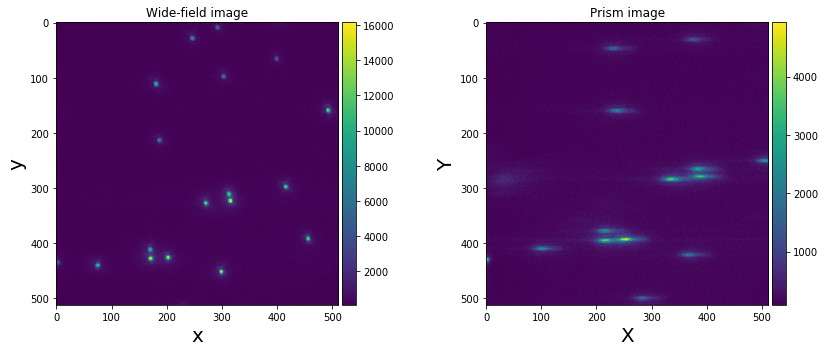

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
im = {}
fig, ax = plt.subplots(1,2, figsize=(12,5))
im[0] = ax[0].imshow(image_dot)
im[1] = ax[1].imshow(image_prism)
ax[0].set_title('Wide-field image')
ax[1].set_title('Prism image')
ax[0].set_xlabel('x', fontsize=20)
ax[0].set_ylabel('y', fontsize=20)
ax[1].set_xlabel('X', fontsize=20)
ax[1].set_ylabel('Y', fontsize=20)


for i in range(2):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im[i], cax=cax)
fig.tight_layout()

### Background subtraction

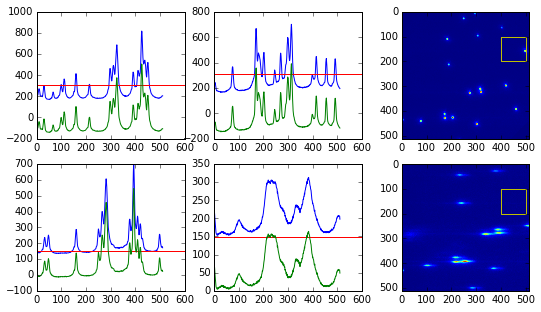

In [8]:
bgroi = (slice(100,200), slice(400,500))
image_dot_bgcr = image_dot - np.mean(image_dot[bgroi])
image_prism_bgcr = image_prism - np.mean(image_prism[bgroi])
fig, ax = plt.subplots(2,3, figsize=(9,5))
ax = ax.ravel()
ax[0].plot(image_dot.mean(1))
ax[0].axhline(y=image_dot[bgroi].mean(), color='r')
ax[0].plot(image_dot_bgcr.mean(1))
ax[1].plot(image_dot.mean(0))
ax[1].axhline(y=image_dot[bgroi].mean(), color='r')
ax[1].plot(image_dot_bgcr.mean(0))
ax[2].plot((bgroi[1].start,bgroi[1].start,bgroi[1].stop,bgroi[1].stop,bgroi[1].start),(bgroi[0].start,bgroi[0].stop,bgroi[0].stop,bgroi[0].start,bgroi[0].start), 'y')
ax[2].imshow(image_dot_bgcr)
ax[3].plot(image_prism.mean(1))
ax[3].axhline(y=image_prism[bgroi].mean(), color='r')
ax[3].plot(image_prism_bgcr.mean(1))
ax[4].plot(image_prism.mean(0))
ax[4].axhline(y=image_prism[bgroi].mean(), color='r')
ax[4].plot(image_prism_bgcr.mean(0))
ax[5].plot((bgroi[1].start,bgroi[1].start,bgroi[1].stop,bgroi[1].stop,bgroi[1].start),(bgroi[0].start,bgroi[0].stop,bgroi[0].stop,bgroi[0].start,bgroi[0].start), 'y')
ax[5].imshow(image_prism_bgcr)

### Find dots' and lines' coordinates

In [9]:
scan = [3,3]
pts_dot = ROI.finddot(image_dot_bgcr, scan, nstd=1.4)
scan = [3,15]
pts_prism = ROI.finddot(image_prism_bgcr, scan, nstd=1.2)

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


##### Exclude duplicates

In [10]:
index = []
for i in range(1, len(pts_dot)-1):
    if np.sum((pts_dot[i] - pts_dot[i+1])**2) >= np.sum(np.array(scan)**2):
        if np.sum((pts_dot[i] - pts_dot[i-1])**2) >= np.sum(np.array(scan)**2):
            index = np.append(index, i)
if np.sum((pts_dot[0] - pts_dot[1])**2) >= np.sum(np.array(scan)**2):
    index = np.append(index, 0)
if np.sum((pts_dot[len(pts_dot)-1] - pts_dot[len(pts_dot)-2])**2) >= np.sum(np.array(scan)**2):
    index = np.append(index, len(pts_dot)-1)  
index = np.unique(index).astype('int')
pts_dot = pts_dot[list(index)]

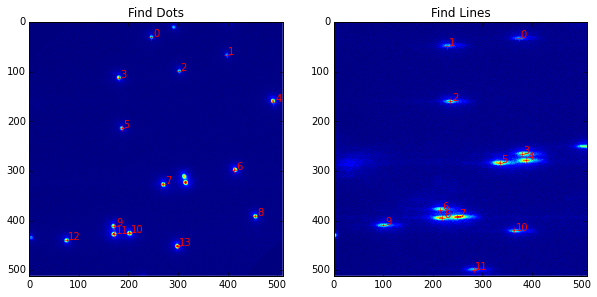

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title('Find Dots')
for count, pt in enumerate(pts_dot):
    ax[0].plot(pt[0],pt[1], 'r+')
    ax[0].annotate(count, xy=pt+[5,0], color='r')
ax[0].imshow(image_dot_bgcr, interpolation='None')
ax[1].set_title('Find Lines')
for count, pt in enumerate(pts_prism):
    ax[1].plot(pt[0],pt[1], 'r+')
    ax[1].annotate(count, xy=pt+[5,0], color='r')
ax[1].imshow(image_prism_bgcr, interpolation='None')

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


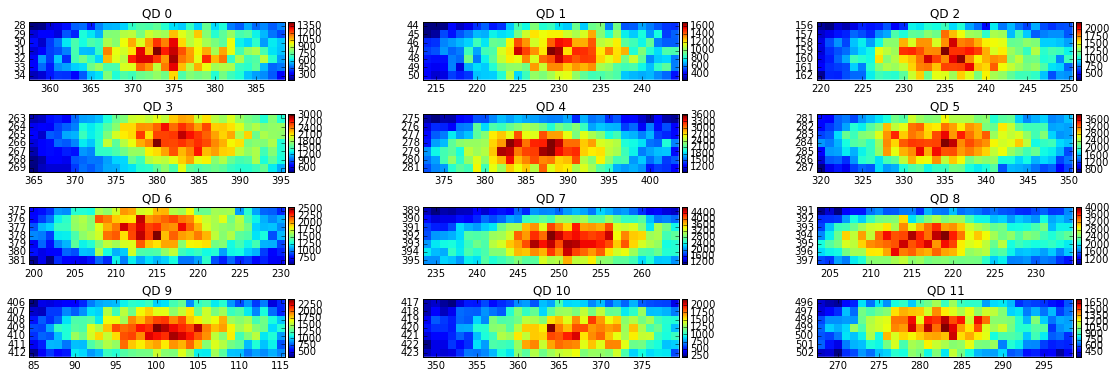

In [12]:
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(int(math.ceil(float(len(pts_prism))/3)), 3, figsize=(20,math.ceil(float(len(pts_prism))/2)))
ax = ax.ravel()
for count, pt in enumerate(pts_prism):    
    roi = ROI.get_roi_square(pt, scan)
    if roi[1].stop-0.5 < 512 and roi[0].stop-0.5 < 512:
        extent = (roi[1].start-0.5, roi[1].stop-0.5, roi[0].stop-0.5, roi[0].start-0.5)
    if roi[1].stop-0.5 < 512 and roi[0].stop-0.5 > 512:
        extent = (roi[1].start-0.5, roi[1].stop-0.5, 512, roi[0].start-0.5)
    if roi[1].stop-0.5 > 512 and roi[0].stop-0.5 < 512:
        extent = (roi[1].start-0.5, 512, roi[0].stop-0.5, roi[0].start-0.5)
    im = ax[count].imshow(image_prism_bgcr[roi], interpolation='none', extent=extent)
    ax[count].set_title('QD {} '.format(count))
    divider = make_axes_locatable(ax[count])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    fig.colorbar(im, cax=cax)  
plt.subplots_adjust(hspace = 0.6) 

### Find dx and dy

In [13]:
shift, mag = (-60.918637535924951, 0.90703524833602123)

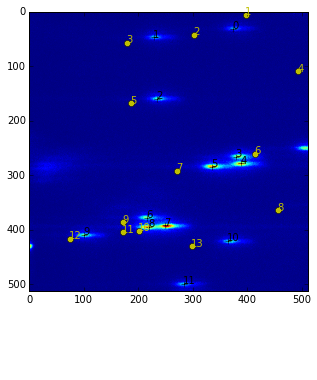

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
for count, pt in enumerate(pts_dot):
    point = (pt[0], (pt[1]+shift)/mag)
    ax.plot(point[0], point[1], 'yo')
    ax.annotate(count, xy=point, color='y')
for count, pt in enumerate(pts_prism):
    point = (pt[0], pt[1])
    ax.plot(point[0], point[1], 'k+')
    ax.annotate(count, xy=point, color='k')
ax.imshow(image_prism_bgcr)

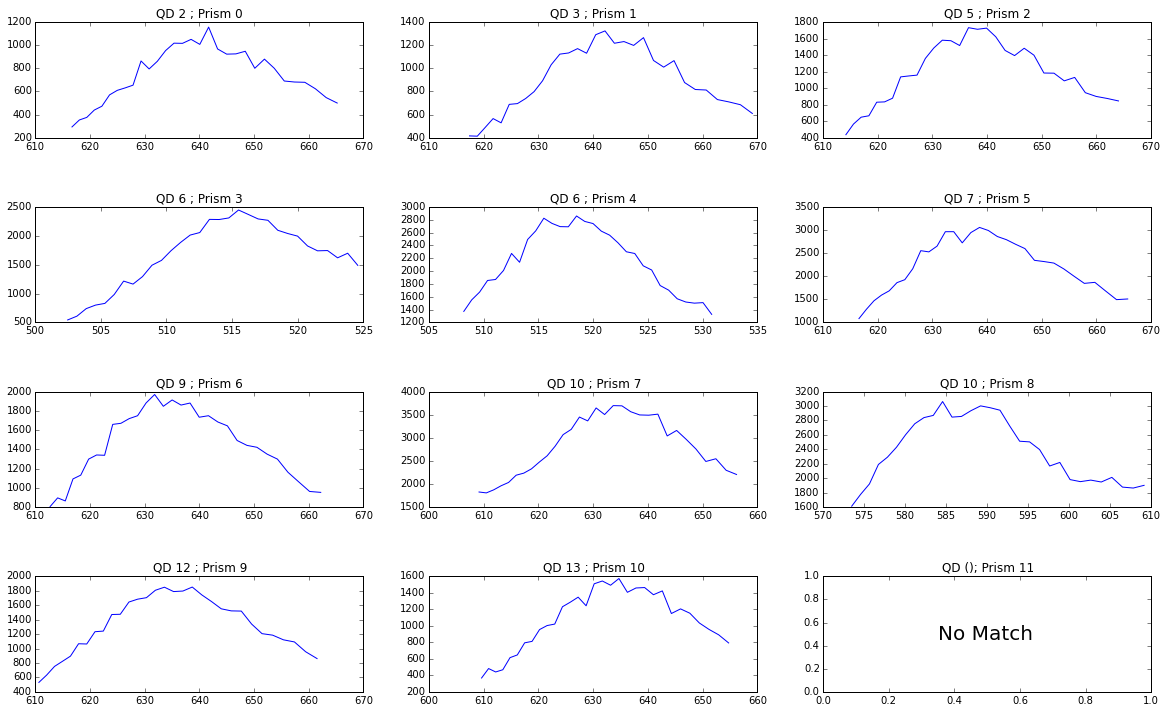

In [15]:
dot = (pts_dot+[0,shift])/[1,mag]
fig, ax = plt.subplots(int(math.ceil(float(len(pts_prism))/3)), 3, figsize=(20,math.ceil(float(len(pts_prism))/2)*2))
ax = ax.ravel()
for count, pt in enumerate(pts_prism):
    dot_index = np.argmin(np.sum(((dot-pt)*scan)**2, axis=1))
    if np.amin(np.sum(((dot-pt)*scan)**2, axis=1)) < 10**6:
        dx, dy = pt-pts_dot[dot_index]
        wavelength_fromX = get_wavelength(pts_dot[dot_index][0], dx, scan, 'x')
        #wavelength_fromY = get_wavelength(pts_dot[dot_index][1], dy, scan, 'y')

        roi = ROI.get_roi_square(pt, scan)
        ax[count].plot(wavelength_fromX, image_prism_bgcr[roi].mean(0), 'b')
        ax[count].set_title('QD {} '.format(dot_index)+'; Prism {} '.format(count))
    else:
        ax[count].annotate('No Match', xy=(0.35,0.45), xycoords='axes fraction', fontsize=20)
        ax[count].set_title('QD ()'+'; Prism {} '.format(count))
plt.subplots_adjust(hspace = 0.6)